 # Residue analysis
 Note: some sections that require a lot of computational time are commented
 and the analyses are done with precomputed results.

First, we load all necessary packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as hcluster
import scipy.stats
import scipy.optimize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

from data_preparation import prepare_data
from data_simulation import (generate_data_mul_process)
from utilities import (unique, ctype_cols, other_ctype_cols)
from summary_plots import (mut_barplot, sample_residues, residue_umaps, channel_scatterplot)
from cluster_plots import (plot_heatmap_with_dendrogram_tri)
from ml import ml_inference_joint

warnings.filterwarnings("ignore", category=UserWarning)

 ## Loading data
 Below we load the mutational signature and their activity data from
 Alexandrov et al. 2020 paper and mutation counts derived from PCAWG samples.

In [2]:
# Processing the data
data_path = "./data/"
Path(data_path).mkdir(parents=True, exist_ok=True)
prepare_data(file_path="./alexandrov_data/", save_to_path=data_path)

# Loading the processed data
# Mutation counts from 2780 PCAWG samples
pcawg_counts = np.loadtxt(data_path + "real_pcawg_mutation_counts.txt")

# "Other" dataset from Alexandrov et al. with additional 1865 samples
other_counts = np.loadtxt(data_path + "real_other_mutation_counts.txt")

# Mutational signatures and activities for both PCAWG and "other" samples
sp_signatures = np.loadtxt(data_path + "sigProfiler_signatures.txt")  # SigProfiler set
sp_activities = np.loadtxt(data_path + "sigProfiler_activities.txt")
sa_activities = np.loadtxt(data_path + "signatureAnalyzer_activities.txt")  # SignatureAnalyzer set
sa_signatures = np.loadtxt(data_path + "signatureAnalyzer_signatures.txt")
other_sp_activities = np.loadtxt(data_path + "sigProfiler_other_activities.txt")

# Predicted mutation counts (additive model, i.e. dot product of mutational
# signature activities and the mutational signatures)
sp_pcawg_fit = np.loadtxt(data_path + "alexandrov_sigProfiler_PCAWG_fitted_counts.txt")
sa_pcawg_fit = np.loadtxt(data_path + "alexandrov_signatureAnalyzer_PCAWG_fitted_counts.txt")
sp_other_fit = np.loadtxt(data_path + "alexandrov_sigProfiler_other_fitted_counts.txt")

# PCAWG and "other" sample labels
pcawg_labels = np.loadtxt(data_path + "pcawg_labels.txt", dtype=str)
pcawg_full_labels = np.loadtxt(data_path + "pcawg_full_labels.txt", dtype=str)
other_labels = np.loadtxt(data_path + "other_labels.txt", dtype=str)
other_full_labels = np.loadtxt(data_path + "other_full_labels.txt", dtype=str)

# Signature names
signature_names = np.loadtxt(data_path + "sigProfiler_signature_names.txt", dtype=str)

 ## Residue example in a single sample
 Here we show an example residual profiles of a single colorectal cancer
 sample SP18121 from PCAWG mutational count data versus SigProfiler model fit.

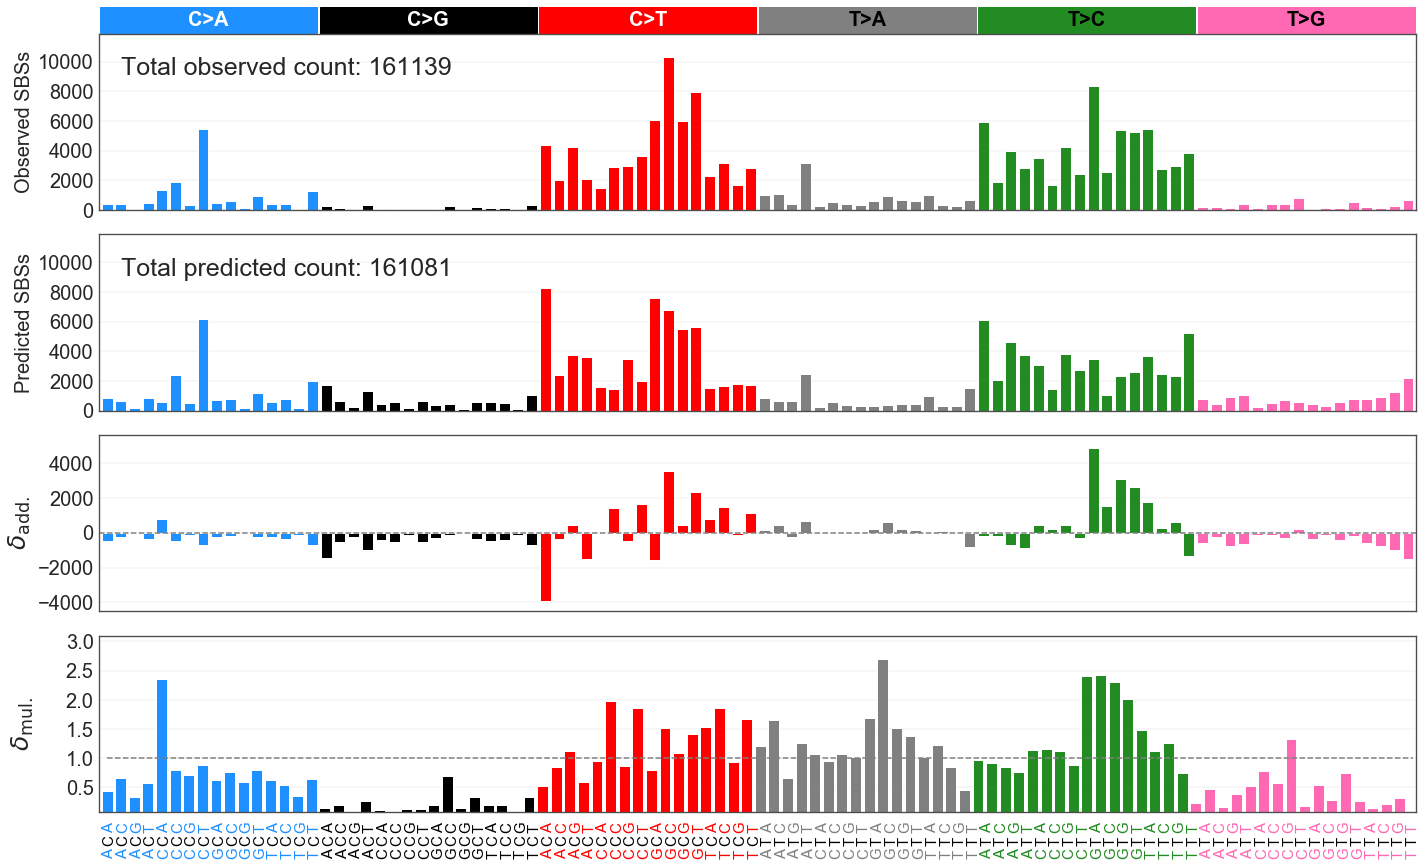

In [3]:
sample_name = "ColoRect-AdenoCA::SP18121"
i = np.where(pcawg_full_labels == sample_name)[0]
cosim = cosine_similarity(pcawg_counts[i].reshape(1, -1),
                          sp_pcawg_fit[i].reshape(1, -1))[0][0]

x = pcawg_counts[i].reshape(1, -1)
y = sp_pcawg_fit[i].reshape(1, -1)

t1 = "Total observed count: " + str(int(np.sum(x)))
t2 = "Total predicted count: " + str(int(np.sum(y)))

sample_residues(x=x, y=y, title="", text_annotations=[t1, t2, "", ""])


 ## Residue manifold approximation (UMAP)
 Here we check if there's any obvious structure in the residual profiles
 in the PCAWG samples.

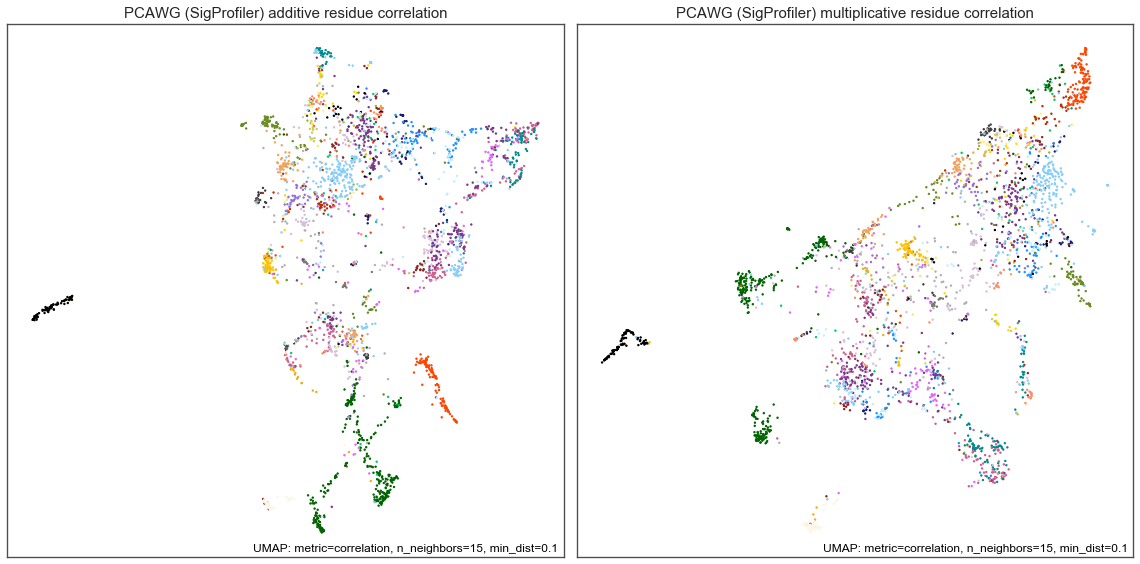

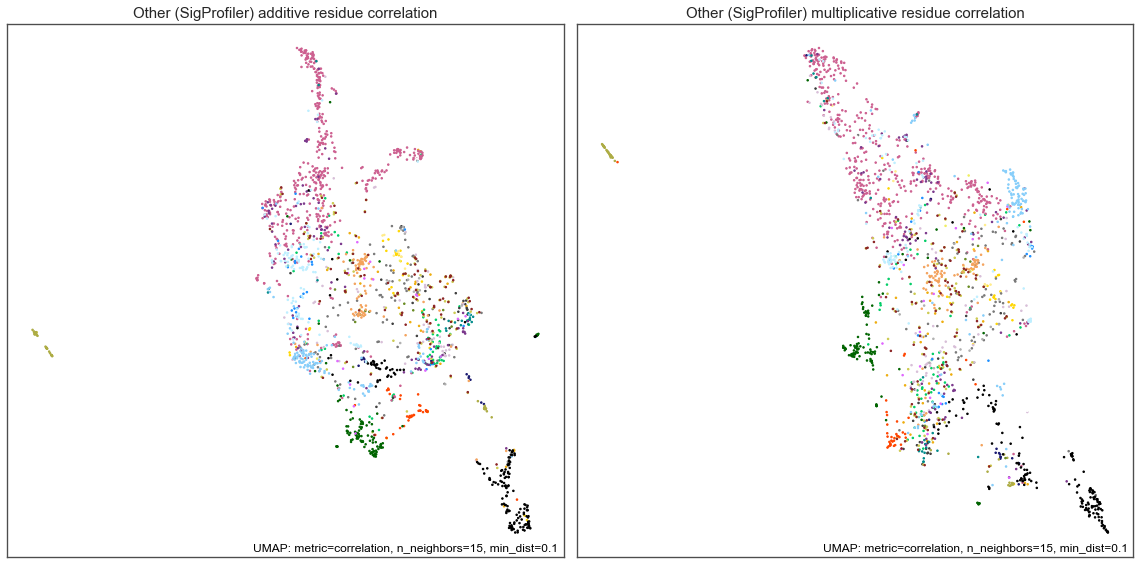

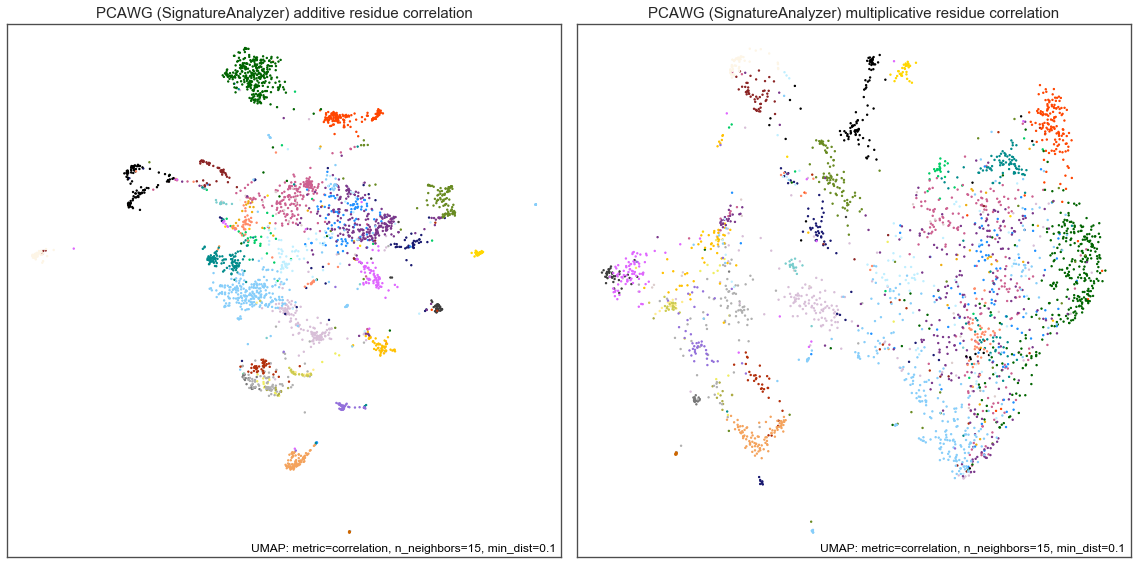

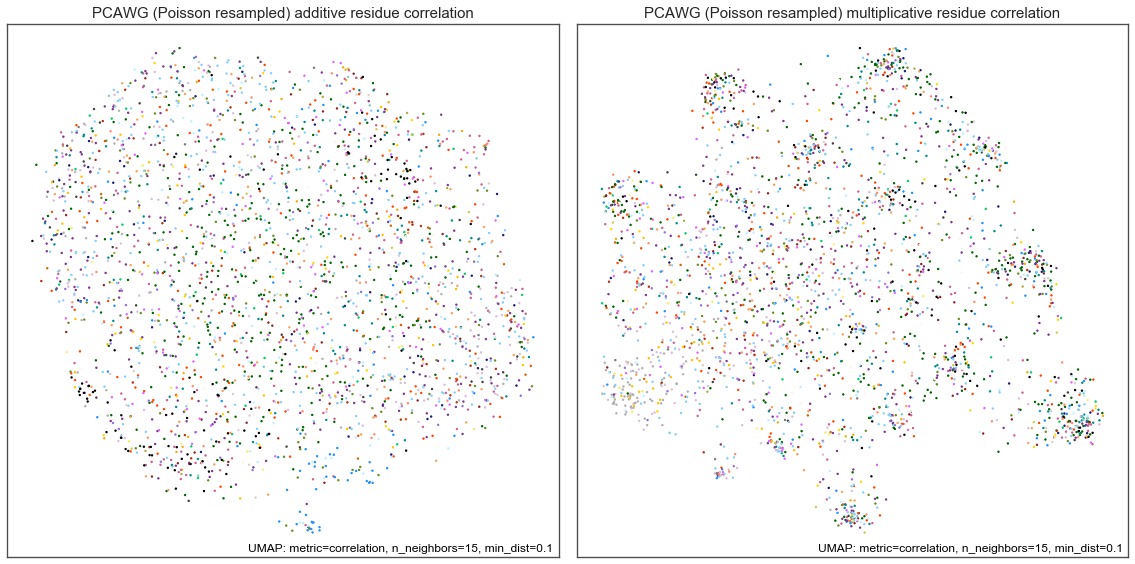

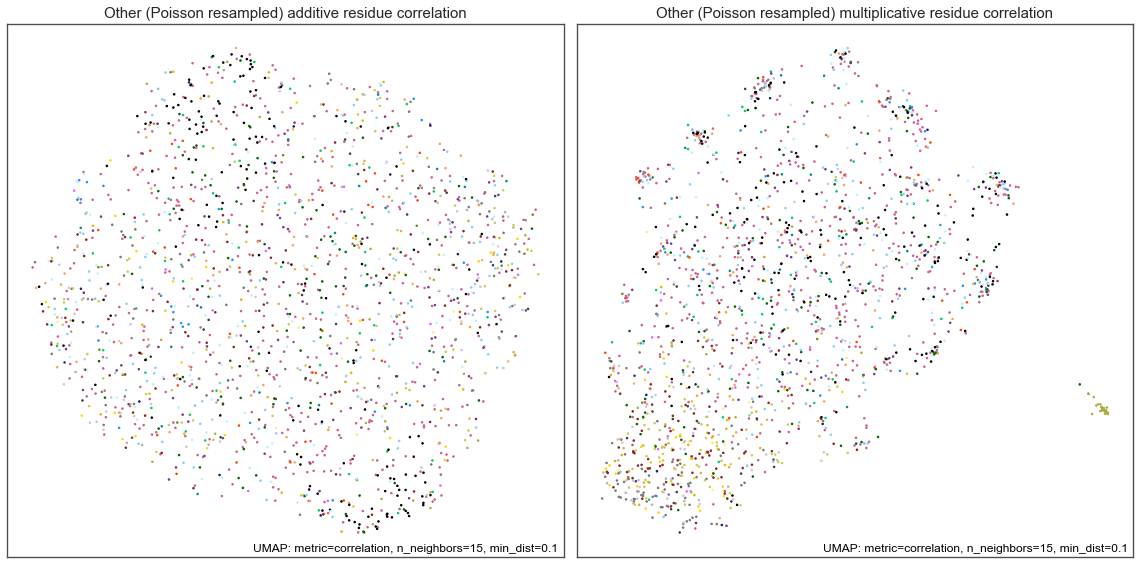

In [5]:
# PCAWG SigProfiler fits
residue_umaps(x=pcawg_counts, y=sp_pcawg_fit,
              labels=pcawg_labels, ctype_cols=ctype_cols,
              data_title="PCAWG (SigProfiler)")

# Other SigProfiler fits
residue_umaps(x=other_counts, y=sp_other_fit,
              labels=other_labels, ctype_cols=other_ctype_cols,
              data_title="Other (SigProfiler)")

# PCAWG SignatureAnalyzer fits
residue_umaps(x=pcawg_counts, y=sa_pcawg_fit,
              labels=pcawg_labels, ctype_cols=ctype_cols,
              data_title="PCAWG (SignatureAnalyzer)")

# PCAWG Poisson resampled fits
residue_umaps(x=pcawg_counts, y=scipy.stats.poisson.rvs(pcawg_counts),
              labels=pcawg_labels, ctype_cols=ctype_cols,
              data_title="PCAWG (Poisson resampled)")

# Other Poisson resampled fits
residue_umaps(x=other_counts, y=scipy.stats.poisson.rvs(other_counts),
              labels=other_labels, ctype_cols=other_ctype_cols,
              data_title="Other (Poisson resampled)")

 # Hierarchical clustering of residues
 Below is an example clustering of both multiplicative and additive residues
 of all PCAWG samples (using SigProfiler fits). The result is the two-part
 heatmap where the main clustering is done on the multiplicative residues and
 the additive residues are ordered according to the same order.
 The plots are saved to file to avoid long load times in the notebook due
 to the large plot sizes.

In [3]:
def hierarchical_clustering(x, y, labels, threshold, ctype_colors,
                            filename=None, cluster_labels=False):
    """
    Performs the hierarchical clustering on specified data and optionally
    (if filename is not None) plots the results.

    Args:
        x (matrix): Observed mutation count matrix.
        y (matrix): Predicted mutation count matrix.
        labels (array): Sample labels.
        threshold (float): Threshold for cluster formation.
        ctype_colors (dict): Dictionary assigning colors to each unique label (e.g. cancer type).
        filename (str, optional): File path to save the figure in. Defaults to None.
        cluster_labels (bool, optional): Boolean indicating whether to plot cluster labels. Defaults to False.

    Returns:
        idx (array): clustered indices.
    """

    x1 = x/(y + 1)  # PCAWG SigProfiler mul. residues
    x2 = x - y  # PCAWG SigProfiler add. residues
    Z1 = hcluster.linkage(x1, method="complete",
                          metric="correlation")  # Linkage matrix of mul. residues

    dists1 = np.corrcoef(x1)  # Correlation matrix of mul. residues
    dists2 = np.corrcoef(x2)  # Correlation matrix of add. residues

    fc = hcluster.fcluster(Z1, t=threshold,
                           criterion='distance')  # Forming clusters using threshold
    idx = fc.argsort()  # Get the cluster order

    if filename:
        totals = np.log10(np.sum(x[idx], axis=1).reshape(-1, 1))
        plot_heatmap_with_dendrogram_tri(Z=Z1, dists1=dists1, dists2=dists2,
                                         labels=labels,
                                         ctype_cols=ctype_colors,
                                         totals=totals,
                                         threshold=threshold,
                                         cluster_labels=cluster_labels,
                                         filename=filename,
                                         text_y=-0.15,
                                         vmin=0, vmax=1)

    return fc, idx

The below heatmaps of clustered residue correlations are automatically saved in files.

In [ ]:
# PCAWG SigProfiler fit
_ = hierarchical_clustering(x=pcawg_counts, y=sp_pcawg_fit, threshold=0.75,
                            ctype_colors=ctype_cols,
                            labels=pcawg_labels, cluster_labels=False,
                            filename="./pcawg_sp_tri_mul_vs_add_heatmap.pdf")

# Poisson-resampled PCAWG data "fit" (baseline)
_ = hierarchical_clustering(x=pcawg_counts, y=scipy.stats.poisson.rvs(pcawg_counts), threshold=0.75,
                            ctype_colors=ctype_cols,
                            labels=pcawg_labels, cluster_labels=False,
                            filename="./pcawg_resampled_tri_mul_vs_add_heatmap.pdf")

# PCAWG SignatureAnalyzer fit
_ = hierarchical_clustering(x=pcawg_counts, y=sa_pcawg_fit, threshold=0.75,
                            ctype_colors=ctype_cols,
                            labels=pcawg_labels, cluster_labels=False,
                            filename="./pcawg_sa_tri_mul_vs_add_heatmap.pdf")

# Other SigProfiler fit
_ = hierarchical_clustering(x=other_counts, y=sp_other_fit, threshold=0.75,
                            ctype_colors=other_ctype_cols,
                            labels=other_labels, cluster_labels=False,
                            filename="./other_sp_tri_mul_vs_add_heatmap.pdf")

 ## Cluster analysis
 Here we analyze several clusters from the hierarhical residue clustering
 results.

In [4]:
# Choose the data
counts = pcawg_counts
fit = sp_pcawg_fit
labels = pcawg_labels
ct_colors = ctype_cols
threshold = 0.75

# Get the clusters
fc, idx = hierarchical_clustering(x=counts, y=fit, threshold=0.75,
                                  ctype_colors=ct_colors,
                                  labels=labels)

# Choosing the cluster number. 58 here represents the large Liver-HHC cluster.
clusterno = 58
cluster_indices = np.where(fc == clusterno)[0]
cluster_labels = np.array(labels)[cluster_indices]

cluster_real = counts[cluster_indices] + 1
cluster_fit = fit[cluster_indices] + 1
print(cluster_labels)

['Biliary-AdenoCA' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-H

 Plotting summary statistics and observed vs. predicted mutation scatterplot
 of the cluster chosen above.

C>A done.
C>G done.
C>T done.
T>A done.
T>C done.
T>G done.


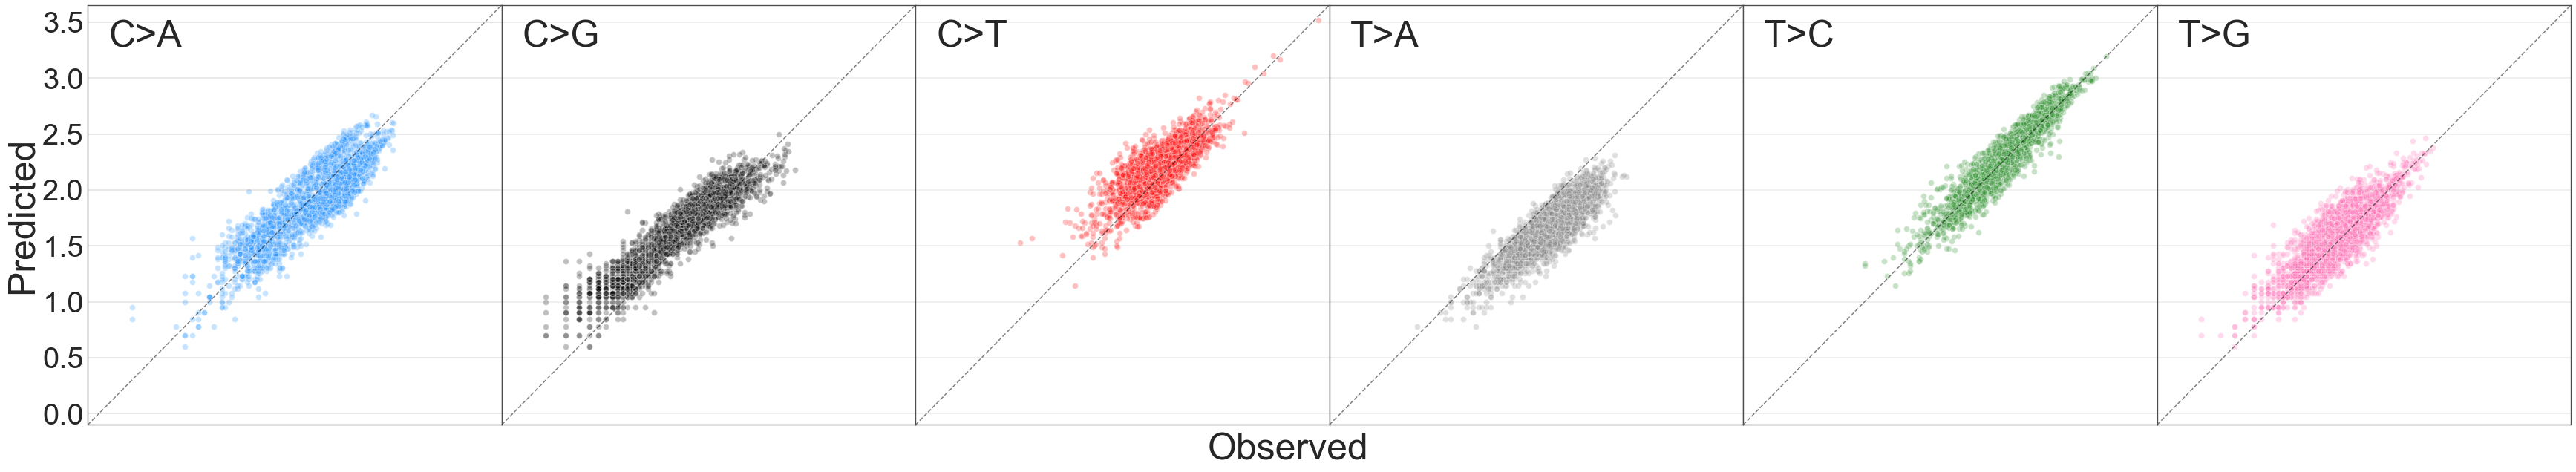

In [9]:
channel_scatterplot(obs=cluster_real, pred=cluster_fit,
                    title=None, filename=None)

 Below we display the cluster entropy histogram and some summary statistics.
 To rank the clusters, we use their entropy (from the frequencies of the sample
 labels within the cluster) and alphabet (how many unique labels within the
 cluster).

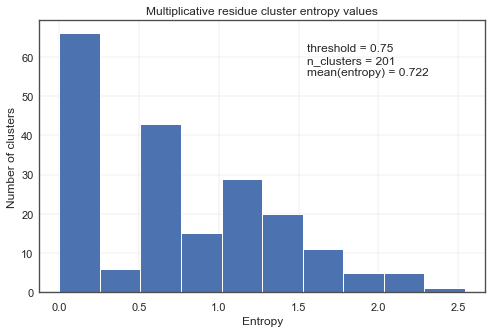

In [10]:
alphabets = np.zeros(len(np.unique(fc)))
entropies = np.zeros(len(np.unique(fc)))
label_counts = np.zeros(len(np.unique(fc)))
for i in range(len(entropies)):
    cluster_indices = np.where(fc == i+1)[0]
    cluster_labels = np.array(labels)[cluster_indices]
    entropies[i] = scipy.stats.entropy(np.unique(cluster_labels, return_counts=True)[1]/cluster_labels.shape[0])
    alphabets[i] = len(unique(cluster_labels))
    label_counts[i] = len(cluster_labels)

en_df = pd.DataFrame(data=[range(1, len(entropies) + 1), entropies, alphabets, label_counts],
                     index=["Cluster", "Entropy", "Alphabet", "Samples"]).T.set_index('Cluster')
en_df = en_df.sort_values(["Entropy", "Alphabet"])

sorted_clusters = np.array([x for _, x in sorted(zip(entropies, np.unique(fc)))])
sorted_clusters = np.array([x for _, x in sorted(zip(alphabets, np.unique(fc)))])
sorted_entropies = np.array([x for _, x in sorted(zip(alphabets, entropies))])

plt.figure(figsize=(8, 5))
hist_n, hist_bins, hist_patches = plt.hist(entropies)
plt.title("Multiplicative residue cluster entropy values")
plt.xlabel("Entropy")
plt.ylabel("Number of clusters")
plt.text(0.6, 0.8, "threshold = "
                   + str(threshold)
                   + "\nn_clusters = "
                   + str(len(entropies))
                   + "\nmean(entropy) = "
                   + str(np.round(np.mean(entropies), 3)), transform=plt.gca().transAxes)
plt.show()

 Below is the list of clusters (only those that have no less than 10 samples),
 ranked first by entropy and then by the alphabet. First 4 clusters
 (104, 111, 120 and 129) are melanoma clusters with the lowest entropy (zero).

In [11]:
print("%s\t%s\t%s\t%s" % ("Index", "Entropy", "Alphabet", "No. of samples"))
for index, row in en_df[en_df['Samples'] >= 10].iterrows():
    print("%s\t%s\t%s\t\t%s" % (int(index), np.round(row['Entropy'], 2), row['Alphabet'], row['Samples']))

Index	Entropy	Alphabet	No. of samples
104	0.0	1.0		18.0
111	0.0	1.0		17.0
120	0.0	1.0		14.0
129	0.0	1.0		10.0
152	0.0	1.0		11.0
174	0.0	1.0		10.0
58	0.14	4.0		163.0
57	0.22	2.0		17.0
144	0.31	2.0		43.0
27	0.45	2.0		12.0
6	0.59	3.0		44.0
84	0.6	3.0		11.0
170	0.61	4.0		19.0
158	0.79	4.0		17.0
80	0.82	6.0		104.0
168	0.86	3.0		11.0
151	0.87	9.0		101.0
50	0.89	4.0		17.0
46	0.9	4.0		19.0
164	0.92	3.0		30.0
67	0.92	3.0		16.0
49	0.94	3.0		20.0
145	1.01	6.0		47.0
12	1.02	5.0		27.0
5	1.08	4.0		12.0
169	1.1	6.0		24.0
10	1.11	8.0		113.0
150	1.12	5.0		36.0
77	1.13	4.0		12.0
155	1.13	5.0		19.0
149	1.16	4.0		13.0
86	1.24	4.0		11.0
105	1.27	4.0		13.0
163	1.29	6.0		13.0
64	1.32	9.0		33.0
71	1.33	6.0		25.0
78	1.36	5.0		10.0
146	1.44	5.0		14.0
172	1.47	7.0		27.0
73	1.48	8.0		23.0
85	1.48	7.0		33.0
167	1.48	6.0		19.0
11	1.49	7.0		30.0
66	1.54	6.0		22.0
54	1.55	5.0		12.0
166	1.57	9.0		39.0
153	1.58	6.0		12.0
70	1.67	13.0		92.0
74	1.71	8.0		21.0
51	1.71	9.0		36.0
76	1.72	6.0		11.0
121	1.75	7.0		10.0
60	1.78

 # Maximum likelihood inference of modulatory processes
 ## Simulated data

In [ ]:
# Data simulation with a fake modulatory process which affects two out of 6 base channels
# by reducing counts in one and increasing in the other
# Warning! May take a long time to complete. Skip to avoid execution, subsequent
# analyses can be used with precomputed results (next cell).

np.random.seed(2)
path = "./simulated_data/"
sim_r_full = np.zeros((50, 96))
sim_c_full = np.zeros((50, 100))
inf_r_full = np.zeros((50, 96))
inf_c_full = np.zeros((50, 100))
for i in range(50):
    sim_c = np.array([-2])
    sim_r = np.array([1])
    while np.min(1 + sim_c.reshape(1, -1)*sim_r.reshape(-1, 1)) < 0:
        sim_c = np.random.uniform(low=0, high=1, size=100)  # Random activities
        sim_r = np.random.normal(0, 0.05, size=96)  # Initialize with noise
        lb = np.random.choice(6, 2, replace=False)  # Choose two out of 6 SBS types
        sim_r[lb[0]*16:lb[0]*16+16] = np.random.uniform(0, 1, 16)  # Affected positively
        sim_r[lb[1]*16:lb[1]*16+16] = np.random.uniform(0, 1, 16)*(-1)  # Affected negatively
        sim_r_full[i, :] = sim_r
        sim_c_full[i, :] = sim_c
        sim_c = sim_c*np.max(np.abs(sim_r))
        sim_r = sim_r/np.max(np.abs(sim_r))  # Normalize the modulatory signature

    chosen_sigs = sp_signatures[np.random.choice(sp_signatures.shape[0], size=10)]

    generate_data_mul_process(c=sim_c, mp=sim_r, multiplier=500, N_samples=100,
                              N_signatures=chosen_sigs.shape[0], N_active_signatures=4,
                              data_path=path, filename="simulated_" + str(i),
                              signatures=chosen_sigs, manual_signatures=True)

    sim_data = np.loadtxt(path + "simulated_" + str(i) + "-samples.txt")
    sim_mu = np.loadtxt(path + "simulated_" + str(i) + "-mu.txt")
    sim_x = np.loadtxt(path + "simulated_" + str(i) + "-x.txt")
    sim_x_pre = np.loadtxt(path + "simulated_" + str(i) + "-x_pre.txt")
    sim_data_affected = np.dot(sim_x, sim_mu) + 1
    sim_labels = np.array(["Simulated_" + str(i) + "::sample" + str(j) for j in range(100)])

    # mut_barplot(sim_r, "Simulated", hline=0, ylim=(-1.1, 1.1), annotate_types=True)

    ml_inference_joint(counts=sim_data, signatures=sim_mu, activities=sim_x,
                       full_labels=sim_labels, plot=False, infer_activities=True,
                       path=path + "simulated_inference/")

    inf_r_full[i] = pd.read_csv(path + "simulated_inference/r_all.csv",
                                sep=",").set_index('0').loc["Simulated_" + str(i)].to_numpy()
    inf_c_full[i] = pd.read_csv(path + "simulated_inference/Simulated_" + str(i) + "_c.csv",
                    sep=",").iloc[:, 1].to_numpy()

    # mut_barplot(inf_r_full[i], "Inferred", hline=0, ylim=(-1.1, 1.1), annotate_types=True)

np.savetxt("./simulated_data/sim_r_full.txt", sim_r_full, fmt='%.10f')
np.savetxt("./simulated_data/sim_c_full.txt", sim_c_full, fmt='%.10f')
np.savetxt("./simulated_data/inf_r_full.txt", inf_r_full, fmt='%.10f')
np.savetxt("./simulated_data/inf_c_full.txt", inf_c_full, fmt='%.10f')

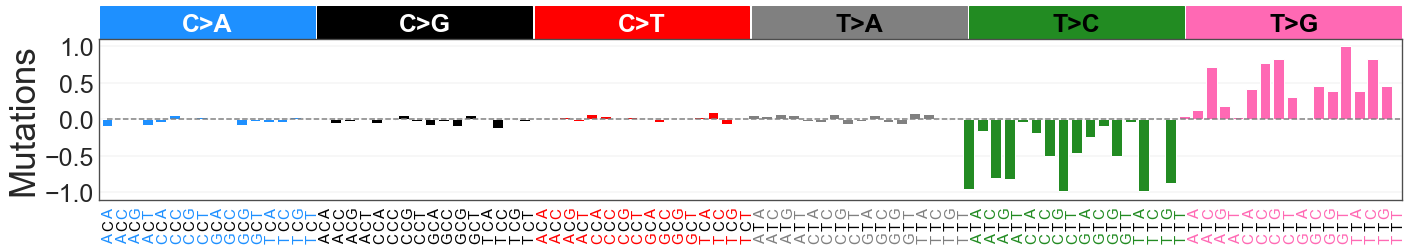

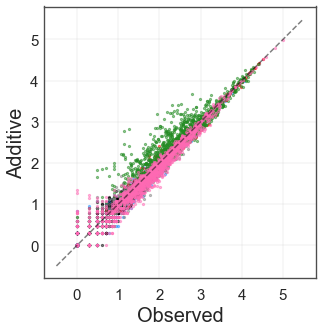

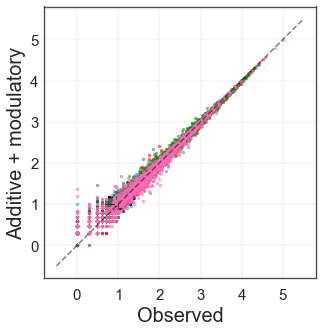

In [24]:
# We also plot the simulated versus inferred activities to see how accurate
# they are (the dataset loaded below is the same as in the manuscript results).
# Uncomment below to use precomputed results.

"""
inf_r_full = np.loadtxt("./simulated_data/inf_r_full.txt")
inf_c_full = np.loadtxt("./simulated_data/inf_c_full.txt")
sim_r_full = np.loadtxt("./simulated_data/sim_r_full.txt")
sim_c_full = np.loadtxt("./simulated_data/sim_c_full.txt")
"""

path = "./simulated_data/"
muts_cols = ['dodgerblue', 'black', 'red', 'grey', 'forestgreen', 'hotpink']

i = 5

mut_barplot(sim_r_full[i]/np.max(np.abs(sim_r_full[i])), "", ylim=(-1.1, 1.1), annotate_types=True, hline=0)

plt.figure(figsize=(5, 5))
plt.plot([-0.5, 5.5], [-0.5, 5.5], linestyle='dashed', color='black', alpha=0.5)
temp_data = (np.loadtxt(path + "simulated_" + str(i) + "-samples.txt") + 1).astype(int)
temp_a = pd.read_csv(path + "simulated_inference/" + "Simulated_" + str(i) + "_a.csv").iloc[:, 1:].to_numpy()
temp_sigs = np.loadtxt(path + "simulated_" + str(i) + "-mu.txt")
temp_fit = (np.dot(temp_a, temp_sigs) + 1).astype(int)
for j in range(6):
    plt.scatter(np.log10(temp_data[:, j*16:(j+1)*16]),
                np.log10(temp_fit[:, j*16:(j+1)*16]),
                c=muts_cols[j],
                s=5, alpha=0.5)
plt.axis('square')
plt.xlabel("Observed", fontsize=20)
plt.ylabel("Additive", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
# plt.savefig("./obs_v_pred_single.png")
# plt.close()

plt.figure(figsize=(5, 5))
plt.plot([-0.5, 5.5], [-0.5, 5.5], linestyle='dashed', color='black', alpha=0.5)
temp_data = (np.loadtxt(path + "simulated_" + str(i) + "-samples.txt") + 1).astype(int)
temp_a = pd.read_csv(path + "simulated_inference/" + "Simulated_" + str(i) + "_a.csv").iloc[:, 1:].to_numpy()
temp_sigs = np.loadtxt(path + "simulated_" + str(i) + "-mu.txt")
temp_fit = np.dot(temp_a, temp_sigs) + 1
temp_r = inf_r_full[i]/np.max(np.abs(inf_r_full[i]))
temp_c = inf_c_full[i]*np.max(np.abs(inf_r_full[i]))
temp_corr = (temp_fit*(1 + temp_r.reshape(1, -1)*temp_c.reshape(-1, 1)) + 1).astype(int)
for j in range(6):
    plt.scatter(np.log10(temp_data[:, j*16:(j+1)*16]),
                np.log10(temp_corr[:, j*16:(j+1)*16]),
                c=muts_cols[j],
                s=5, alpha=0.5)
plt.axis('square')
plt.xlabel("Observed", fontsize=20)
plt.ylabel("Additive + modulatory", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
# plt.savefig("./obs_v_corr_single.png")
# plt.close()


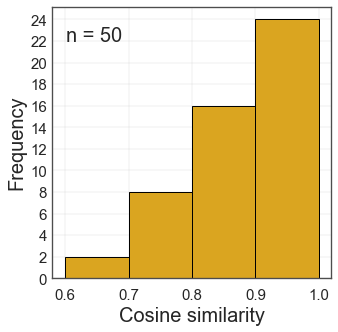

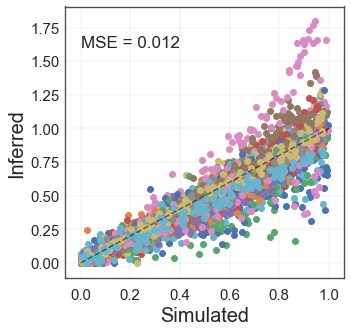

In [25]:
plt.figure(figsize=(5, 5))
n, bins, edges = plt.hist(cosine_similarity(sim_r_full/np.max(np.abs(sim_r_full)),
                                            inf_r_full/np.max(np.abs(inf_r_full))).diagonal(),
                          color="goldenrod", edgecolor="black", align="mid", bins=4)
plt.grid('axes')
ax = plt.gca()
ax.set_axisbelow(True)
plt.xlabel("Cosine similarity", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xticks(ticks=bins, labels=np.round(bins, 1), fontsize=15)
plt.yticks(ticks=range(0, 26, 2), fontsize=15)
plt.text(0.57, 22, "n = 50", fontsize=20)
plt.show()

plt.figure(figsize=(5, 5))
x = sim_c_full*np.max(np.abs(sim_r_full), axis=1).reshape(-1, 1)
y = inf_c_full*np.max(np.abs(inf_r_full), axis=1).reshape(-1, 1)
for i in range(50):
    plt.scatter(x[i], y[i])
plt.xlabel("Simulated", fontsize=20)
plt.ylabel("Inferred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid('axes')
ax = plt.gca()
ax.set_axisbelow(True)
plt.plot([0, 1], [0, 1], linestyle='dashed', color='black', alpha=0.5)
t = str(np.round(np.mean((x - y)**2), 3))
plt.text(0, 1.6, "MSE = " + t, fontsize=17)
plt.show()

In [26]:
np.mean(cosine_similarity(sim_r_full/np.max(np.abs(sim_r_full)), inf_r_full/np.max(np.abs(inf_r_full))).diagonal())

0.8646283978974971

 ## MPs in clusters

In [25]:
counts = pcawg_counts
fit = sp_pcawg_fit
labels = pcawg_labels
ct_colors = ctype_cols
threshold = 0.75

fc, idx = hierarchical_clustering(x=counts, y=fit, threshold=0.75,
                                  ctype_colors=ct_colors,
                                  labels=labels)

# Choosing the cluster number. 58 here represents the large Liver-HCC cluster.
clusterno = 58
cluster_indices = np.where(fc == clusterno)[0]
cluster_labels = np.array(labels)[cluster_indices]

cluster_real = counts[cluster_indices]
cluster_fit = fit[cluster_indices]
print(cluster_labels)

# Dummy labels for MP inference algorithm
dummy_labels = np.array(["Cluster" + str(clusterno) + "::sample" + str(i) for i in range(len(cluster_labels))])

['Biliary-AdenoCA' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-H

In [28]:
ml_inference_joint(counts=cluster_real,
                   signatures=sp_signatures,
                   activities=sp_activities[cluster_indices],
                   full_labels=dummy_labels,
                   path="./cluster_mp_inference/", plot=False)
print("Finished.")

Cluster58


c:\Users\Dovydas\Desktop\mp_sig\ml.py:64: RuntimeWarning: invalid value encountered in log
  result += X[k, j]*np.log((1 + c[k]*r[j])*lam[k, j]) - (1 + c[k]*r[j])*lam[k, j]


cr inf: Linear search failed
Finished.


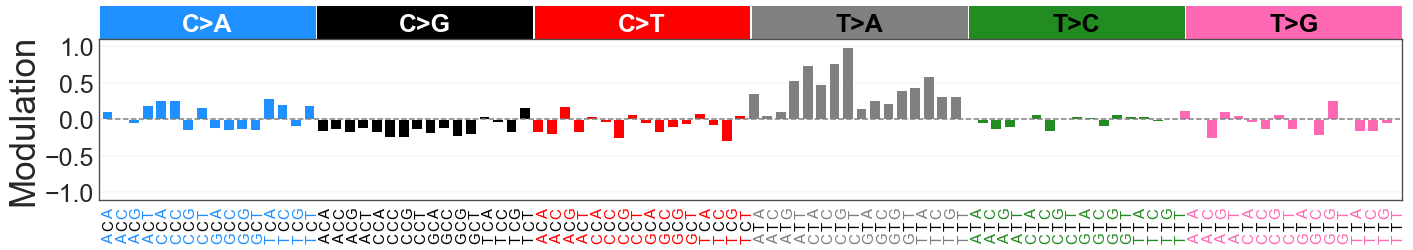

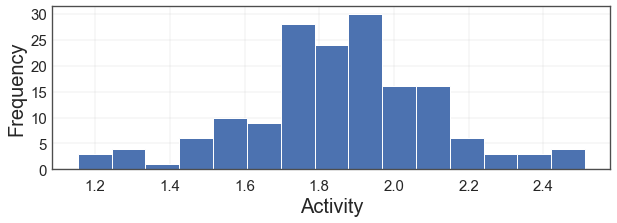

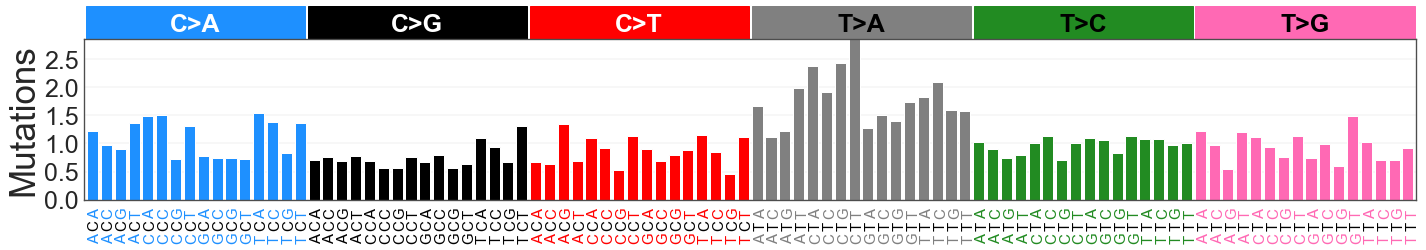

In [30]:
r = pd.read_csv("./cluster_mp_inference/r_all.csv",
                sep=",").set_index('0').loc["Cluster" + str(clusterno)].to_numpy()
c = pd.read_csv("./cluster_mp_inference/Cluster" + str(clusterno) + "_c.csv",
                sep=",").iloc[:, 1].to_numpy()*np.max(np.abs(r))
ll_df = pd.read_csv("./cluster_mp_inference/Cluster" + str(clusterno) + "_ll_change.csv", sep=",")
cluster_corrected = cluster_fit*(1 + c.reshape(-1, 1)*r.reshape(1, -1))

# Modulatory signature
mut_barplot(data=r, title="", ylabel="Modulation", hline=0, ylim=(-1.1, 1.1), annotate_types=True)

# Modulatory signature activities
plt.figure(figsize=(10, 3))
plt.hist(c, bins=15)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Activity", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Impact
mut_barplot(np.mean(1 + c.reshape(-1, 1)*r.reshape(1, -1), axis=0), "", annotate_types=True)

 ## Cancer-type specific modulatory processes

In [ ]:
# Warning! May take a long time to complete. Subsequent analyses use precomputed results.
"""
ml_inference(counts=pcawg_counts, signatures=sp_signatures, activities=sp_activities,
             full_labels=pcawg_full_labels, plot=False,
             path="./cancer_mp_inference/")
print("Finished.")
"""

In [4]:
# Loading data and pre-computed results of MP inference in different cancer types.
path = "./cancer_mp_inference/"
labels = pcawg_labels
counts = pcawg_counts
fit = sp_pcawg_fit
rdf = pd.read_csv(path + "r_all.csv", delimiter=",").set_index("0")

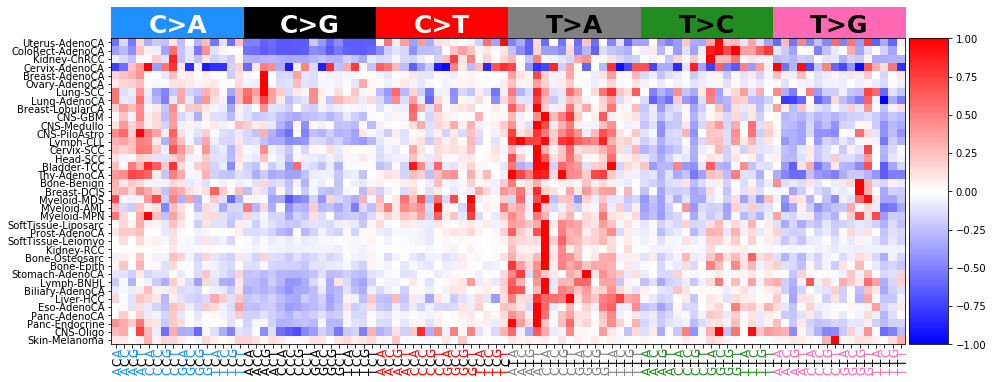

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

mut_xlabs = ['ACA', 'ACC', 'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT',
             'GCA', 'GCC', 'GCG', 'GCT', 'TCA', 'TCC', 'TCG', 'TCT',
             'ACA', 'ACC', 'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT',
             'GCA', 'GCC', 'GCG', 'GCT', 'TCA', 'TCC', 'TCG', 'TCT',
             'ACA', 'ACC', 'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT',
             'GCA', 'GCC', 'GCG', 'GCT', 'TCA', 'TCC', 'TCG', 'TCT',
             'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT',
             'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT',
             'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT',
             'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT',
             'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT',
             'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT']
mut_type_colors = (["dodgerblue"]*16 + ["black"]*16 + ["red"]*16 +
                   ["grey"]*16 + ["forestgreen"]*16 + ["hotpink"]*16)
channel6 = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
col_list = ["dodgerblue", "black", "red", "grey", "forestgreen", "hotpink"]

x = rdf.to_numpy()/np.max(np.abs(rdf.to_numpy()), axis=1).reshape(-1, 1)
Z = hcluster.linkage(x, method="complete", metric="cosine")
fc = hcluster.fcluster(Z, t=0.5, criterion='distance')
idx = fc.argsort()

plt.figure(figsize=(15, 10))
plt.imshow(x[idx], cmap="bwr")
ax = plt.gca()
text_col = ["w", "w", "w", "black", "black", "black"]
for j in range(6):
    left, width = 0 + 1/6 * j, 1/6
    bottom, height = 1.003, 0.1
    right = left + width
    top = bottom + height
    ax = plt.gca()
    p = plt.Rectangle((left, bottom), width, height, fill=True, color=col_list[j])
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(0.5 * (left + right), 0.495 * (bottom + top), channel6[j],
            color=text_col[j], weight='bold', size=25,
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)
    ax.margins(x=0.002, y=0.002)

for k in range(len(mut_xlabs)):
    plt.text(k/len(mut_xlabs), -0.03, mut_xlabs[k][2],
                color=mut_type_colors[k], rotation=90, fontsize=12, transform=ax.transAxes)
    plt.text(k/len(mut_xlabs), -0.06, mut_xlabs[k][1],
                color='black', rotation=90, fontsize=12, transform=ax.transAxes)
    plt.text(k/len(mut_xlabs), -0.09, mut_xlabs[k][0],
                color=mut_type_colors[k], rotation=90, fontsize=12, transform=ax.transAxes)
plt.xticks(range(96), [""]*96, rotation=90)
plt.yticks(range(len(sorted(unique(labels)))), np.array(sorted(unique(labels)))[idx])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.show()

In [ ]:
# Plotting of all MP inference results.
for ctype in sorted(unique(labels)):
    print(ctype)
    idx = np.where(labels == ctype)[0]
    r = rdf.loc[ctype].to_numpy()
    c = pd.read_csv(path + ctype + "_c.csv", sep=",").iloc[:, 2].to_numpy()
    repaired = (fit[idx]*(1 + c.reshape(-1, 1)*r.reshape(1, -1))).astype(int)
    mut_barplot(r, title=ctype+" inferred multiplicative process", ylabel="Multiplier", hline=0.0,
                filename=path + ctype + "_mp.png", ylim=(-1, 1))

    # Plotting scatterplots takes a lot of time!
    """
    channel_scatterplot(counts[idx], repaired, title=None,
                        filename=path + ctype + "_repaired_scatter.png")
    """

    fig = plt.figure(figsize=(8, 5))
    plt.hist(c, bins=20)
    plt.title(ctype + " multiplicative process activity histogram")
    plt.xlabel("Activity")
    plt.ylabel("Frequency")
    plt.savefig(path + ctype + "_activity_hist.png")
    plt.close(fig)

In [11]:
# Gathering of data for LL-gain plots
labels = pcawg_labels
counts = pcawg_counts
activities = sp_activities
signatures = sp_signatures
fit = np.dot(activities, signatures)
path = "./cancer_mp_inference/"
rdf = pd.read_csv(path + "r_all.csv", delimiter=",").set_index("0")

# For equal spacing in LL-gain plot
# (326 is the largest number of cancer samples of one type, i.e. Liver-HCC)
max_samples = 326
ll_diffs = np.zeros((len(unique(labels)), max_samples))
ll_means = np.zeros(len(unique(labels)))
c_activities = np.zeros((len(unique(labels)), max_samples))

sum_means = np.zeros(len(unique(labels)))
sums = np.zeros((len(unique(labels)), max_samples))
totals = np.zeros((len(unique(labels)), max_samples))
add_muts = np.zeros((len(unique(labels)), max_samples))

rem_muts = np.zeros((len(unique(labels)), max_samples))
mean_impact = np.zeros((len(unique(labels)), 96))
i = 0
for ctype in sorted(unique(labels)):
    print(i, ctype)
    ctype_ll = pd.read_csv(path + ctype + "_ll_change.csv", sep=",")
    ctype_r = rdf.loc[ctype].to_numpy()
    ctype_c = pd.read_csv(path + ctype + "_c.csv", sep=",").iloc[:, 2].to_numpy()
    ctype_idx = np.where(labels == ctype)[0]
    ctype_counts = counts[ctype_idx]
    ctype_fit = fit[ctype_idx]
    ctype_rep = (ctype_fit*(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1))).astype(int)

    temp_sums = np.full(max_samples, np.nan)
    temp_totals = np.full(max_samples, np.nan)
    temp_activities = np.full(max_samples, np.nan)

    temp_mut_add = np.full(max_samples, np.nan)
    temp_mut_rem = np.full(max_samples, np.nan)
    mut_diff = ctype_rep - ctype_fit

    sample_mut_added = np.zeros(len(mut_diff))
    sample_mut_removed = np.zeros(len(mut_diff))

    for k in range(len(mut_diff)):
        sample = mut_diff[k]
        sample_mut_added[k] = np.sum(sample[sample > 0])
        sample_mut_removed[k] = np.sum(sample[sample < 0])

    boundary = int((max_samples - len(ctype_ll))/2)

    temp_activities[boundary:boundary + len(ctype_ll)] = ctype_c
    c_activities[i] = temp_activities

    temp_mut_add[boundary:boundary + len(ctype_ll)] = sample_mut_added
    temp_mut_rem[boundary:boundary + len(ctype_ll)] = sample_mut_removed
    add_muts[i] = temp_mut_add
    rem_muts[i] = temp_mut_rem

    mean_impact[i] = np.mean(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1), axis=0)

    temp_sums[boundary:boundary + len(ctype_ll)] = np.sum(np.abs(mut_diff), axis=1)
    temp_totals[boundary:boundary + len(ctype_ll)] = np.sum(ctype_counts, axis=1)
    ll_diff = np.abs(ctype_ll["After"].abs() - ctype_ll["Before"].abs())
    temp = np.full(max_samples, np.nan)
    temp[boundary:boundary + len(ctype_ll)] = ll_diff
    ll_diffs[i] = temp
    ll_means[i] = np.mean(np.log10(ll_diff + 1))
    sum_means[i] = np.mean(np.sum(np.abs(mut_diff), axis=1))
    sums[i] = temp_sums
    totals[i] = temp_totals
    i += 1

0 Biliary-AdenoCA
1 Bladder-TCC
2 Bone-Benign
3 Bone-Epith
4 Bone-Osteosarc
5 Breast-AdenoCA
6 Breast-DCIS
7 Breast-LobularCA
8 CNS-GBM
9 CNS-Medullo
10 CNS-Oligo
11 CNS-PiloAstro
12 Cervix-AdenoCA
13 Cervix-SCC
14 ColoRect-AdenoCA
15 Eso-AdenoCA
16 Head-SCC
17 Kidney-ChRCC
18 Kidney-RCC
19 Liver-HCC
20 Lung-AdenoCA
21 Lung-SCC
22 Lymph-BNHL
23 Lymph-CLL
24 Myeloid-AML
25 Myeloid-MDS
26 Myeloid-MPN
27 Ovary-AdenoCA
28 Panc-AdenoCA
29 Panc-Endocrine
30 Prost-AdenoCA
31 Skin-Melanoma
32 SoftTissue-Leiomyo
33 SoftTissue-Liposarc
34 Stomach-AdenoCA
35 Thy-AdenoCA
36 Uterus-AdenoCA


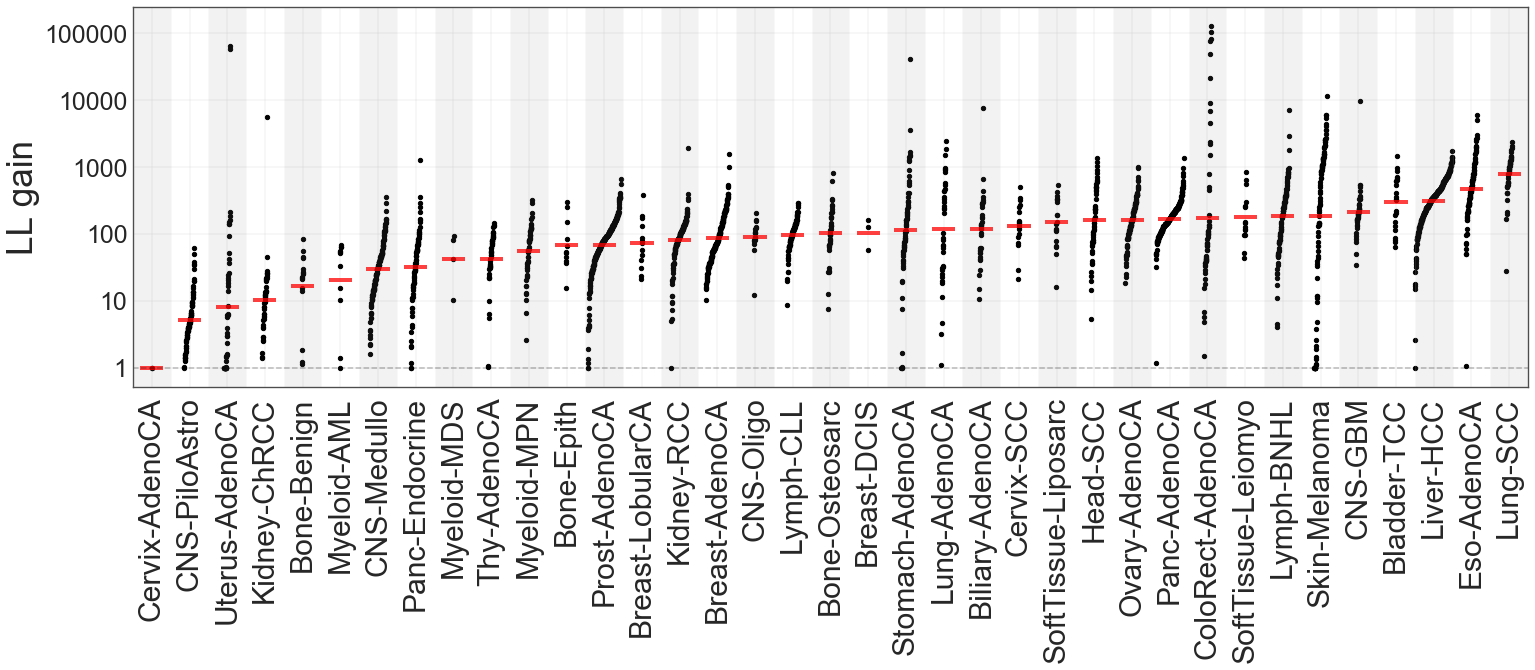

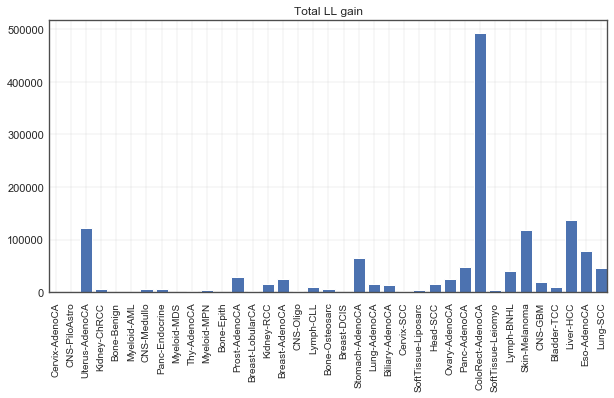

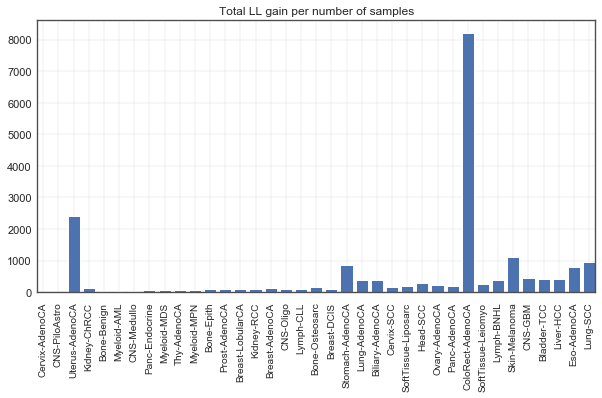

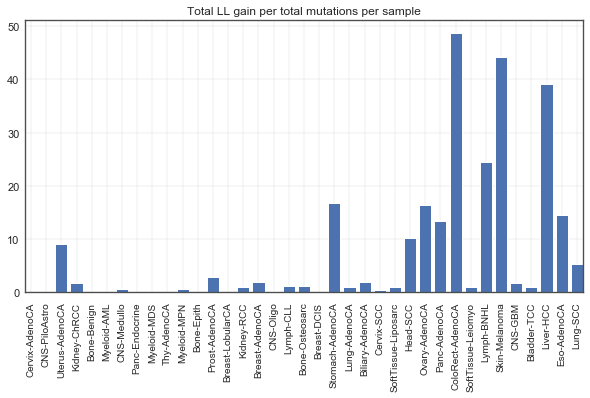

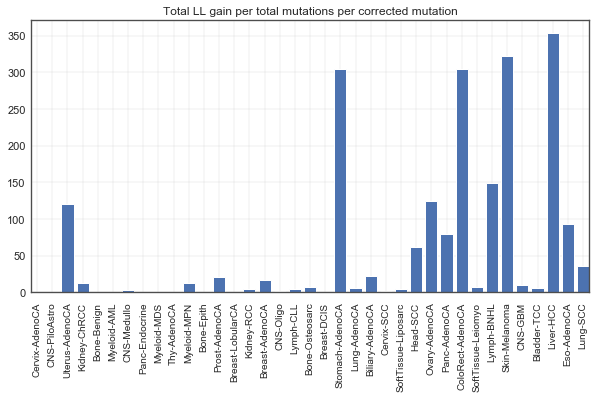

In [12]:
# Plotting the log-likelihood gain per cancer type per sample
plt.figure(figsize=(25, 7))
idx = np.array(range(len(unique(labels))))
idx = np.array([x for _, x in sorted(zip(ll_means, idx))])
prev = 0
c = 0
ll_gain_per_sample = []
total_ll_gain = []
ll_gain_per_corrected = []
ll_gain_per_total = []
for i in idx:
    y = sorted(np.log10(np.abs(ll_diffs[i]) + 1))
    temp = ll_diffs[i][~np.isnan(ll_diffs[i])]
    ll_gain_per_sample.append(int(np.sum(np.abs(temp))/len(temp)))
    ll_gain_per_corrected.append(int(np.sum(np.abs(temp))/(np.abs(add_muts[~np.isnan(add_muts)][i]) +
                                 np.abs(rem_muts[~np.isnan(rem_muts)][i]))))
    total_ll_gain.append(int(np.sum(np.abs(temp))))
    ll_gain_per_total.append(np.sum(temp/totals[~np.isnan(totals)][i]))
    plt.scatter(range(prev, prev + max_samples), y, marker=".", c="black", s=75)
    if c % 2 == 0:
        plt.axvspan(prev, prev + max_samples, facecolor='grey', alpha=0.1)
    plt.hlines(ll_means[i],
               prev + int(max_samples/2) - 100, prev + int(max_samples/2) + 100,
               color="red", alpha=0.75, linewidth=4)
    prev += max_samples
    c += 1

plt.xticks(range(int(max_samples/2), max_samples*len(unique(pcawg_labels)), max_samples),
           np.array(sorted(unique(pcawg_labels)))[idx], rotation=90, fontsize=30)
# plt.gca().set_yticklabels()
plt.yticks(ticks=1 + plt.yticks()[0], labels=[str(10**x) for x in range(int(plt.ylim()[1]) + 1)], fontsize=25)

plt.hlines(0, 0, max_samples*len(unique(pcawg_labels)), color="black", linestyle="--", alpha=0.25)
plt.ylabel("LL gain", fontsize=35)
# plt.title("Per-sample log-likelihood gain", fontsize=30)
plt.margins(x=0)
plt.show()

# Total log-likelihood gain per cancer type
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted(unique(pcawg_labels)))), total_ll_gain)
plt.xticks(range(len(sorted(unique(pcawg_labels)))),
           np.array(sorted(unique(pcawg_labels)))[idx], rotation=90, fontsize=10)
plt.title("Total LL gain")
plt.margins(x=0)
plt.show()

# Total log-likelihood gain per cancer type (normalized by number of samples)
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted(unique(pcawg_labels)))), ll_gain_per_sample)
plt.xticks(range(len(sorted(unique(pcawg_labels)))),
           np.array(sorted(unique(pcawg_labels)))[idx], rotation=90, fontsize=10)
plt.title("Total LL gain per number of samples")
plt.margins(x=0)
plt.show()

# Total log-likelihood gain per cancer type (normalized by total mutations)
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted(unique(pcawg_labels)))), ll_gain_per_total)
plt.xticks(range(len(sorted(unique(pcawg_labels)))),
           np.array(sorted(unique(pcawg_labels)))[idx], rotation=90, fontsize=10)
plt.title("Total LL gain per total mutations per sample")
plt.margins(x=0)
plt.show()

# Total log-likelihood gain per cancer type (normalized by the number of corrected mutations)
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted(unique(pcawg_labels)))), ll_gain_per_corrected)
plt.xticks(range(len(sorted(unique(pcawg_labels)))),
           np.array(sorted(unique(pcawg_labels)))[idx], rotation=90, fontsize=10)
plt.title("Total LL gain per total mutations per corrected mutation")
plt.margins(x=0)
plt.show()

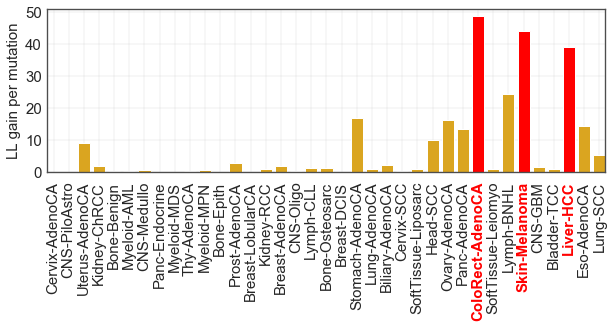

In [13]:
plt.figure(figsize=(10, 3))
bars = plt.bar(range(len(sorted(unique(pcawg_labels)))), ll_gain_per_total, color="goldenrod")
plt.xticks(range(len(sorted(unique(pcawg_labels)))),
           np.array(sorted(unique(pcawg_labels)))[idx], rotation=90, fontsize=15)
# plt.title("Total LL gain per total mutations per sample")
bars[28].set_facecolor("red")
bars[31].set_facecolor("red")
bars[34].set_facecolor("red")
plt.margins(x=0)
plt.grid('axes')
ax = plt.gca()
ax.set_axisbelow(True)
ax.get_xticklabels()[28].set_color("red")
ax.get_xticklabels()[31].set_color("red")
ax.get_xticklabels()[34].set_color("red")
ax.get_xticklabels()[28].set_fontweight("bold")
ax.get_xticklabels()[31].set_fontweight("bold")
ax.get_xticklabels()[34].set_fontweight("bold")
plt.ylabel("LL gain per mutation", fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [3]:
path = "./cancer_mp_inference/"
labels = pcawg_labels
full_labels = pcawg_full_labels
counts = pcawg_counts
activities = sp_activities
signatures = sp_signatures
fit = sp_pcawg_fit
rdf = pd.read_csv(path + "r_all.csv", delimiter=",").set_index("0")

ll_gains = []
real_counts = np.array([]).reshape(0, 96)
fit_counts = np.array([]).reshape(0, 96)
corrected_counts = np.array([]).reshape(0, 96)
mean_impacts = np.array([]).reshape(0, 96)
sig_attr = np.array([]).reshape(0, activities.shape[1])
sig_corr_attr = np.array([]).reshape(0, activities.shape[1])
i = 0
for ctype in sorted(unique(labels)):
    print(i, ctype)
    ctype_ll = pd.read_csv(path + ctype + "_ll_change.csv", sep=",")
    ll_gains.append(np.abs(ctype_ll["After"].abs() - ctype_ll["Before"].abs()).to_numpy())
    ctype_r = rdf.loc[ctype].to_numpy()
    ctype_c = pd.read_csv(path + ctype + "_c.csv", sep=",").iloc[:, 2].to_numpy()
    ctype_idx = np.where(labels == ctype)[0]
    ctype_counts = counts[ctype_idx]
    ctype_fit = fit[ctype_idx]
    ctype_rep = (ctype_fit*(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1))).astype(int)
    impact = np.mean(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1), axis=0)
    mean_impacts = np.vstack([mean_impacts, impact])

    ctype_count_df = pd.DataFrame(data=ctype_counts)
    ctype_count_df["Sample"] = full_labels[ctype_idx]
    ctype_count_df = ctype_count_df.set_index("Sample")
    ctype_count_df.to_csv(path + ctype + "_real_counts.csv", sep=",")
    real_counts = np.vstack([real_counts, ctype_count_df.to_numpy()])

    ctype_fit_df = pd.DataFrame(data=ctype_fit)
    ctype_fit_df["Sample"] = full_labels[ctype_idx]
    ctype_fit_df = ctype_fit_df.set_index("Sample")
    ctype_fit_df.to_csv(path + ctype + "_fit_counts.csv", sep=",")
    fit_counts = np.vstack([fit_counts, ctype_fit_df.to_numpy()])
    fit_residue_sums = np.sum(np.abs(ctype_count_df.to_numpy() - ctype_fit_df.to_numpy()), axis=1)
    fit_mul_residue_sums = np.mean(ctype_count_df.to_numpy()/(ctype_fit_df.to_numpy() + 1), axis=1)
    fit_res_kl = scipy.stats.entropy(ctype_count_df.to_numpy() + 1, ctype_fit_df.to_numpy() + 1, axis=1)

    ctype_rep_df = pd.DataFrame(data=ctype_rep)
    ctype_rep_df["Sample"] = full_labels[ctype_idx]
    ctype_rep_df = ctype_rep_df.set_index("Sample")
    ctype_rep_df.to_csv(path + ctype + "_corrected_counts.csv", sep=",")
    corrected_counts = np.vstack([corrected_counts, ctype_rep_df.to_numpy()])
    corrected_residue_sums = np.sum(np.abs(ctype_count_df.to_numpy() - ctype_rep_df.to_numpy()), axis=1)
    corrected_mul_residue_sums = np.mean(ctype_count_df.to_numpy()/(ctype_rep_df.to_numpy() + 1), axis=1)
    corrected_res_kl = scipy.stats.entropy(ctype_count_df.to_numpy() + 1, ctype_rep_df.to_numpy() + 1, axis=1)

    idx = np.where(labels == ctype)[0]
    resi_attr = activities[idx]/np.sum(activities[idx], axis=1).reshape(-1, 1)
    corr_attr = resi_attr*np.sum(ctype_rep_df.to_numpy(), axis=1).reshape(-1, 1)
    sig_attr = np.vstack([sig_attr, np.sum(activities[idx], axis=0)])
    sig_corr_attr = np.vstack([sig_corr_attr, np.sum(corr_attr, axis=0)])

    plt.figure(figsize=(5, 5))
    plt.boxplot([np.log10(np.sum(ctype_count_df.to_numpy(), axis=1) + 1),
                 np.log10(fit_residue_sums + 1),
                 np.log10(corrected_residue_sums + 1)], vert=False)
    plt.title(ctype)
    plt.yticks(range(1, 4), ["Total\nmutations", "Additive\nresidues", "Corrected\nresidues"], fontsize=12)
    plt.xlabel("Mutations (log10)")
    plt.tight_layout()
    plt.savefig(path + "impacts/" + ctype + "_muts")
    plt.close()

    mut_barplot(mean_impacts[i], "", "Impact", hline=1, ylim=(0, np.max(mean_impacts[i] + 0.1)), annotate_types=True,
                filename=path + "impacts/" + ctype + "_impact")

    normsums = np.sum(ctype_count_df.to_numpy(), axis=1)
    b1 = scipy.stats.entropy(scipy.stats.poisson.rvs(ctype_count_df.to_numpy()) + 1, ctype_count_df.to_numpy() + 1,
                             axis=1)
    b2 = fit_res_kl
    b3 = corrected_res_kl

    line_props = dict(alpha=0.25)
    bbox_props = dict(alpha=0.25)

    plt.figure(figsize=(10, 5))
    strip_data = pd.DataFrame(data={'Model': ['Baseline']*len(idx) + ['Alexandrov']*len(idx) + ['Ours']*len(idx),
                                    'Value': np.array([b1] + [b2] + [b3]).reshape(1, -1)[0],
                                    'Mutations': np.array([normsums]*3).reshape(1, -1)[0]})
    plot = sns.stripplot(x='Model', y='Value', hue='Mutations', data=strip_data,
                         palette='ocean', jitter=True, alpha=0.75)
    plt.boxplot([b1,
                 b2,
                 b3], widths=(0.5, 0.5, 0.5), positions=range(3),
                whiskerprops=line_props, boxprops=bbox_props, showfliers=False)
    plt.xticks(range(3), ["Baseline", "Original", "Modulated"], fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Model", fontsize=20)
    plt.ylabel("KL divergence", fontsize=20)
    plot.get_legend().set_visible(False)
    sns.despine()

    normalize = mcolors.Normalize(vmin=strip_data['Mutations'].min(), vmax=strip_data['Mutations'].max())
    colormap = cm.ocean

    for n in strip_data['Mutations']:
        plt.plot(color=colormap(normalize(n)))

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(strip_data['Mutations'])
    cbar = plt.colorbar(scalarmappaple)
    cbar.set_label("Mutations", fontsize=20)
    cbar.ax.tick_params(labelsize=15)
    # plt.title("Normalized total additive residue")
    plt.savefig(path + "impacts/" + ctype + "_strip_sums")
    plt.close()

    i += 1

ll_gains = np.concatenate(ll_gains)

0 Biliary-AdenoCA
1 Bladder-TCC
2 Bone-Benign
3 Bone-Epith
4 Bone-Osteosarc
5 Breast-AdenoCA
6 Breast-DCIS
7 Breast-LobularCA
8 CNS-GBM
9 CNS-Medullo
10 CNS-Oligo
11 CNS-PiloAstro
12 Cervix-AdenoCA
13 Cervix-SCC
14 ColoRect-AdenoCA
15 Eso-AdenoCA
16 Head-SCC
17 Kidney-ChRCC
18 Kidney-RCC
19 Liver-HCC
20 Lung-AdenoCA
21 Lung-SCC
22 Lymph-BNHL
23 Lymph-CLL
24 Myeloid-AML
25 Myeloid-MDS
26 Myeloid-MPN
27 Ovary-AdenoCA
28 Panc-AdenoCA
29 Panc-Endocrine
30 Prost-AdenoCA
31 Skin-Melanoma
32 SoftTissue-Leiomyo
33 SoftTissue-Liposarc
34 Stomach-AdenoCA
35 Thy-AdenoCA
36 Uterus-AdenoCA


In [ ]:
# Heatmap of corrected residues
_ = hierarchical_clustering(x=real_counts, y=corrected_counts, threshold=0.75,
                            ctype_colors=ctype_cols,
                            labels=pcawg_labels, cluster_labels=False,
                            filename="./pcawg_sp_corrected_tri_mul_vs_add_heatmap.pdf")

 ## Prediction of LL-gain and the number of corrected mutations

In [4]:
activities = sp_activities
labels = pcawg_labels
total_counts = np.sum(activities, axis=1).reshape(-1, 1)
corrected_muts = np.sum(np.abs(real_counts - corrected_counts), axis=1).reshape(-1, 1)
model_comp_data = [[activities, ll_gains, labels],
                   [np.log10(activities + 1), np.log10(ll_gains + 1), labels],
                   [activities/total_counts, np.concatenate(ll_gains.reshape(-1, 1)/total_counts), labels],
                   [activities, corrected_muts, labels],
                   [np.log10(activities + 1), np.log10(corrected_muts + 1), labels],
                   [activities/total_counts, np.concatenate(corrected_muts.reshape(-1, 1)/total_counts), labels]]

rf = RandomForestRegressor()
group_cv = StratifiedKFold(n_splits=5, shuffle=True)
num_cvs = 10
results = []

for n in range(len(model_comp_data)):
    x = model_comp_data[n][0]
    y = model_comp_data[n][1]
    z = model_comp_data[n][2]
    foldscores = np.zeros((num_cvs, 5))

    for i in range(num_cvs):
        j = 0
        signature_importances = np.zeros(x.shape[1])
        scores = []

        for train_i, test_i in group_cv.split(x, z):
            train_x, test_x = x[train_i], x[test_i]
            train_y, test_y = y[train_i], y[test_i]
            rf.fit(train_x, train_y)
            fimp = rf.feature_importances_
            signature_importances += fimp
            pred_y = rf.predict(test_x)
            score = rf.score(test_x, test_y)
            scores.append(score)
            foldscores[i, j] = score
            xmax = np.max([np.max(test_y), np.max(pred_y)])
            j += 1

        print(str(np.mean(scores)))
        signature_importances /= 5
    results.append(foldscores)

for i in range(len(results)):
    results[i] = np.concatenate(results[i])

0.9100888934694777
0.8488236476925991
0.878529008155452
0.8153096013219109
0.8549673095646005
0.8623025237976739
0.757363833146826
0.8902191273845059
0.8740671461120144
0.922936035932738
0.6866713458560673
0.7026529701420655
0.6905017260262224
0.6978864050095254
0.7006110556721794
0.6890794547416799
0.698666042070588
0.7020310919328411
0.6934625871870055
0.6947640708219067
0.3237164797841805
0.32167083249252404
0.30954438280972163
0.3118255679542311
0.30489762057268
0.30604416073608076
0.30142867962062087
0.3030764090084532
0.2867338197986328
0.31508113770891916
0.7518721447007641
0.7175883552995377
0.7546291669481298
0.7280412663132141
0.7056960857899611
0.7766273739917613
0.7863462963199895
0.7695244795212679
0.8056968749227232
0.7881375548167925
0.9373096963875571
0.9323755506775517
0.9342344471380241


In [ ]:
# Plotting the CV results
plt.figure(figsize=(10, 5))
plt.boxplot([results[0], results[1], results[2], results[3], results[4], results[5]])
plt.xlabel("Data model", fontsize=20)
plt.ylabel("R^2 score", fontsize=20)
plt.xticks(range(1, 7), ["LL", "log10(LL)", "norm(LL)", "CM", "log10(CM)", "norm(CM)"], fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
# Relationship between SBS5 and log-likelihood gain
sigind = np.where(signature_names == "SBS5")[0]
idx = np.where(sp_activities[:, sigind] != 0)[0]
x = np.log10(sp_activities[idx, sigind] + 1)
y = np.log10(ll_gains[idx] + 1)
m, b = np.polyfit(x, y, 1)
plt.figure(figsize=(5, 5))
plt.plot(x, m*x + b, color="black", linestyle="-", linewidth=2, alpha=0.25)
plt.scatter(x, y, alpha=0.5, s=5, c="lightseagreen")
plt.xlabel("SBS5 activity (log10)", fontsize=15)
plt.ylabel("Log-likelihood gain (log10)", fontsize=15)
plt.text(x=0, y=5, fontsize=15, s="Slope: " + str(np.round(m, 2)) + ", intercept: " + str(np.round(b, 2)))
plt.text(x=0, y=5.5, s="Pearson correlation: " + str(np.round(np.corrcoef(x, y)[0, 1], 3)), fontsize=15)
plt.xlim(-0.3, 6)
plt.ylim(-0.3, 6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Top 5 most important signatures in best model
rf = RandomForestRegressor()
rf.fit(model_comp_data[4][0], model_comp_data[4][1])  # Best result, log10(CM)
fimp = rf.feature_importances_

sorted_pairs = sorted(zip(fimp, signature_names))
fimp_sorted, signature_names_sorted = [list(tuple) for tuple in zip(*sorted_pairs)]

plt.figure(figsize=(5, 3))
barlist = plt.bar(range(5), fimp_sorted[::-1][:5], color="goldenrod")
barlist[0].set_color('lightseagreen')
plt.xticks(range(5), signature_names_sorted[::-1][:5], rotation=90, fontsize=15)
plt.ylabel("Importance", fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.6)
plt.show()

In [ ]:
# Each signature mutation load contribution to Liver cancer samples
canc = "Liver-HCC"
tot_cg = 0
tot_ta = 0
for i in range(len(signature_names)):
    sig_ind = np.where(signature_names == signature_names[i])[0]
    sample_ind = np.where(pcawg_labels == canc)[0]
    sig = sp_signatures[sig_ind][0]
    total_act = np.sum(sp_activities[sample_ind, sig_ind])
    print(signature_names[i])
    cg = int(np.sum((sig*total_act)[16:32]))
    ta = int(np.sum((sig*total_act)[48:64]))
    tot_cg += cg
    tot_ta += ta
    print(cg)
    print(ta)
    print()

print(tot_cg)
print(tot_ta)

In [ ]:
# Toal observed mutations in C>G and T>A channels in liver cancers
sample_ind = np.where(pcawg_labels == canc)[0]
samp = pcawg_counts[sample_ind]
print("C>G observed:", int(np.sum(samp[:, 16:32])))
print("T>A observed:", int(np.sum(samp[:, 48:64])))

# Total predicted
samp = sp_pcawg_fit[sample_ind]
print("C>G predicted:", int(np.sum(samp[:, 16:32])))
print("T>A predicted:", int(np.sum(samp[:, 48:64])))